# Transform ARGO-KE products into DGGS (Healpix)


## Context

### Purpose

The goal is to have the ARGO-KE into DGGS (healpix grid).

### Description

In this notebook, we will:
- Download the GEBCO Gridded Bathymetry Data
- Transform the downloaded GEBCO dataset into DGGS Healpix
- Save the GEBCO Gridded Bathymetry Data in Zarr

## Contributions

### Notebook

- Ola Formo Kihle (author), Independent Consultant / UW Contractor, (Norway), @ofk123
- Even Moa Myklebust (reviewer), Simula Research Laboratory (Norway), @evenmm
- Anne Fouilloux (reviewer), Simula Research Laboratory (Norway), @annefou


## Bibliography and other interesting resources

- [ARGO Data sources](https://argo.ucsd.edu/data/)
- [Global Ocean Gridded L 4 Sea Surface Heights And Derived Variables Reprocessed Copernicus Climate Service](https://doi.org/10.48670/moi-00145)


## Install packages
- If `xdggs` and/or `xarray-healpy` are not available in your Python environment, uncomment the cells below to install these packages.

In [1]:
#!pip install git+https://github.com/xarray-contrib/xdggs.git

In [2]:
#!pip install git+https://github.com/IAOCEA/xarray-healpy.git

## Install Libraries

In [3]:
import xarray as xr, numpy as np
import s3fs
import xdggs
_ = xr.set_options(display_expand_data=False)

## Open ARGO-KE data product 
- The data sample is stored in a bucket on PANGEO-EOSC and is readable by anyone.

In [4]:
s3 = s3fs.S3FileSystem(
    anon=True,
    endpoint_url='https://pangeo-eosc-minioapi.vm.fedcloud.eu/'
)
s3_bucket= 'okihle-workathon/'
store_s3 = s3fs.S3Map(
    root=s3_bucket + 'argo-vel-data',
    s3=s3,
    check=False
)
ds = xr.open_zarr(store_s3, consolidated=True)

## Visualise velocity

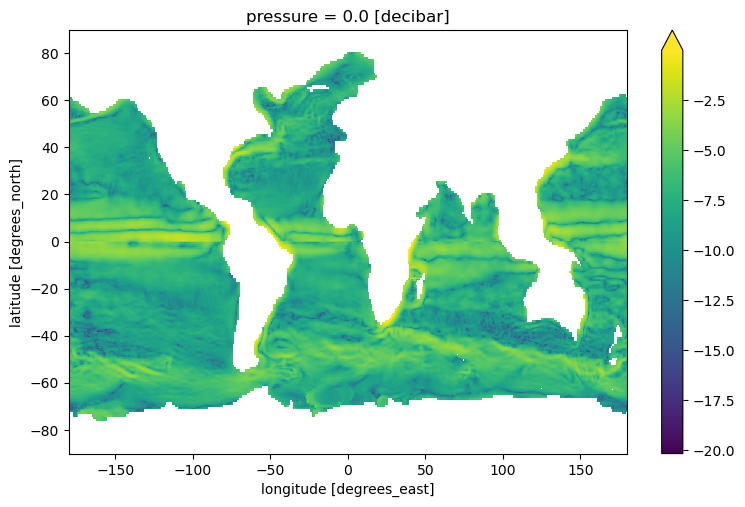

In [5]:
np.log(0.5 * (ds.u**2 + ds.v**2)).compute().plot(
    figsize=(9, 5.5), cmap="viridis", vmax=-0.01
)

## Prepare Healpix grid for regridding

In [6]:
nside = 256

In [7]:
def center_longitude(ds, center):
    if center == 0:
        centered = (ds.longitude + 180) % 360 - 180
    else:
        centered = (ds.longitude - 180) % 360 + 180
    return ds.assign_coords(longitude=centered)

In [8]:
from xarray_healpy import HealpyGridInfo, HealpyRegridder

In [9]:
# Define the target Healpix grid information
grid = HealpyGridInfo(level=int(np.log2(nside)))
target_grid = grid.target_grid(ds).pipe(center_longitude, 0).drop_attrs(deep=False).dggs.decode({"grid_name": "healpix", "nside": nside, "indexing_scheme": "nested"})

## Compute the interpolation weights for regridding the diff data

In [10]:
%%time
regridder = HealpyRegridder(
    ds[["longitude", "latitude"]].compute(),
    target_grid,
    method="bilinear",
    interpolation_kwargs={},
)
regridder

CPU times: user 7.84 s, sys: 441 ms, total: 8.28 s
Wall time: 8.3 s


HealpyRegridder(method='bilinear', interpolation_kwargs={})

## Perform the regridding operation using the computed interpolation weights.

In [11]:
%%time
regridded = regridder.regrid_ds(ds).pipe(xdggs.decode)

CPU times: user 1.58 s, sys: 596 ms, total: 2.18 s
Wall time: 2.18 s


## Visualise regridded data with xdggs

In [12]:
da = np.log(0.5 * (regridded.u**2 + regridded.v**2)).compute().squeeze()
da.dggs.explore()

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7435215d…